In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns
# sns.set_style('whitegrid')

# BGA used to set end dates
import datetime

import covid19

## data

In [3]:
# date_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
date_italy_regions_path = covid19.data.download('regioni')


In [4]:
data_italy_regions = pd.read_csv(date_italy_regions_path, parse_dates=['data'], index_col=['data'])
data_italy_regions['totale_terapia_intensiva'] = data_italy_regions['terapia_intensiva'] + data_italy_regions['deceduti']
data_italy_regions['totale_ricoverati'] = data_italy_regions['ricoverati_con_sintomi'] + data_italy_regions['totale_terapia_intensiva']

data_italy_regions.index = data_italy_regions.index.normalize()

print(sorted(data_italy_regions['denominazione_regione'].unique().tolist()))

data_italy_regions.loc[data_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-03-26,Lombardia,10681,1263,4861
2020-03-26,Emilia Romagna,3354,301,1174
2020-03-26,Piemonte,2633,408,449
2020-03-26,Veneto,1447,326,287
2020-03-26,Toscana,1037,259,158
2020-03-26,Liguria,998,154,280
2020-03-26,Marche,977,166,310
2020-03-26,Lazio,878,113,106
2020-03-26,Puglia,480,76,65


## situation report

In [5]:
DAY = np.timedelta64(24 * 60 * 60,'s')

START_FIT = None
CHANGE_FIT_1 = np.datetime64('2020-03-05')
CHANGE_FIT_2 = np.datetime64('2020-03-11')
CHANGE_FIT_3 = np.datetime64('2020-03-15')
STOP_FIT = None

# BGA changed to end on the last data date
# EXTRAPOLTATE = ('2020-02-23', '2020-03-19')
dTomorrow = data_italy_regions.index.max() + datetime.timedelta(days=1)
EXTRAPOLTATE = ('2020-02-23', dTomorrow.strftime("%Y-%m-%d"))

# BGA - molto improvvisato, si puo' certamente fare meglio
autofits = {}
autofits[5,2] = []

for numdays in range(1, 5):
    dNewFitStart = data_italy_regions.index.max() + datetime.timedelta(days=-numdays)
    dOldFitEnd = data_italy_regions.index.max() + datetime.timedelta(days=-(numdays+1))
    autofits[numdays,1] = dNewFitStart.strftime("%Y-%m-%d")
    autofits[numdays,2] = dOldFitEnd.strftime("%Y-%m-%d")
print (autofits[2,1])
print (autofits[2,2])

print (data_italy_regions.index.max().strftime("%Y-%m-%d"))
        
dThreeDaysFitNewStart = datetime.datetime.now() + datetime.timedelta(days=-2)
dThreeDaysFitOldEnd = datetime.datetime.now() + datetime.timedelta(days=-3)
sThreeDaysFitNewStart = dThreeDaysFitNewStart.strftime("%Y-%m-%d")
sThreeDaysFitOldEnd = dThreeDaysFitOldEnd.strftime("%Y-%m-%d")

# BGA added to ease what to show
SHOW = ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti' ]
bShowLockdowns = False

# BGA this would make the code behave like yours
# SHOW = ['ricoverati_con_sintomi']
# bShowLockdowns = True

# BGA changed to match the column names, makes easier to have different fits
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': [(None, '2020-03-06'), ('2020-03-07', '2020-03-07'), ('2020-03-08', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-06'), ('2020-03-08', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-07'), ('2020-03-08', '2020-03-19'), ('2020-03-20',  autofits[2,2]), (autofits[2,1], None)]
    },
    'Emilia Romagna': {
        'ricoverati_con_sintomi': [(None, '2020-03-01'), ('2020-03-02', '2020-03-06'), ('2020-03-07', '2020-03-19'), ('2020-03-20',  autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-06'), ('2020-03-07', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-07'), ('2020-03-08', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Veneto': {
        'ricoverati_con_sintomi': [(None, '2020-03-12'), ('2020-03-13', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-06'), ('2020-03-07', '2020-03-12'), ('2020-03-13', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-07'), ('2020-03-07', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Piemonte': {
        'ricoverati_con_sintomi': [(None, '2020-03-10'), ('2020-03-11', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-12'), ('2020-03-13', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20',  autofits[2,2]), (autofits[2,1], None)]
    },
    'Marche': {
        'ricoverati_con_sintomi': [(None, '2020-03-06'), ('2020-03-07', '2020-03-14'), ('2020-03-15', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-12'), ('2020-03-13', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Toscana': {
        'ricoverati_con_sintomi': [(None, '2020-03-09'), ('2020-03-10', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-09'), ('2020-03-10', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Liguria': {
        'ricoverati_con_sintomi': [('2020-03-04', '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Lazio':  {
        'ricoverati_con_sintomi': [(None, '2020-03-14'), ('2020-03-15', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Campania': {
        'ricoverati_con_sintomi': [(None, '2020-03-13'), ('2020-03-14', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'P.A. Trento': {
        'ricoverati_con_sintomi': [(None, '2020-03-13'), ('2020-03-14', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-02-23', '2020-03-16'), ('2020-03-17', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [('2020-02-23', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Puglia': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None,  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Abruzzo': {
        'ricoverati_con_sintomi': [(None, '2020-03-18'), ('2020-03-19', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-15'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-18'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)]
    },
    'P.A. Bolzano': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-18'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)]
    },
    'Basilicata': {
        'ricoverati_con_sintomi': [ ('2020-03-15', '2020-03-16'), ('2020-03-17', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [('2020-03-15', '2020-03-16'), ('2020-03-17', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None,  autofits[2,2]), (autofits[2,1], None)]
    },
    'Calabria': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-15'), ('2020-03-16', '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Friuli Venezia Giulia': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-18'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-18'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Molise': {
        'ricoverati_con_sintomi': [ ('2020-03-19', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [ ('2020-03-19', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [ ('2020-03-19', autofits[2,2]), (autofits[2,1], None)]
    },
    'Sardegna': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Sicilia': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
    'Umbria': {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-18'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-18'), ('2020-03-16', autofits[2,2]), (autofits[2,1], None)]
    },
    "Valle d'Aosta": {
        'ricoverati_con_sintomi': [(None, '2020-03-15'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'terapia_intensiva': [(None, '2020-03-18'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)],
        'deceduti': [(None, '2020-03-18'), ('2020-03-16',  '2020-03-19'), ('2020-03-20', autofits[2,2]), (autofits[2,1], None)]
    },
}
    
DELAY = 12 * DAY
PALETTE_ONE = list(sns.color_palette())
PALETTE = itertools.cycle(PALETTE_ONE)

2020-03-24
2020-03-23
2020-03-26


In [6]:
fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    # BGA changed to cycle in SHOW
    for kind in SHOW:
        exponential_fits = params.get(kind, [(START_FIT, CHANGE_FIT_1), (CHANGE_FIT_1 + DAY, CHANGE_FIT_2), (CHANGE_FIT_2 + DAY, CHANGE_FIT_3), (CHANGE_FIT_3 + DAY, STOP_FIT)])
        fits[region, kind] = []
        for start, stop in exponential_fits:
            try:
                select = (data_italy_regions['denominazione_regione'] == region) & (data_italy_regions[kind] >= 8)
                fits[region, kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[select], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

skipping: Abruzzo None 2020-03-18
skipping: P.A. Bolzano None 2020-03-15
skipping: Basilicata 2020-03-15 2020-03-16
skipping: Basilicata 2020-03-15 2020-03-16
skipping: Basilicata None 2020-03-23
skipping: Basilicata 2020-03-24 None
skipping: Calabria None 2020-03-15
skipping: Calabria None 2020-03-15
skipping: Calabria 2020-03-16 2020-03-19
skipping: Molise 2020-03-19 2020-03-23
skipping: Molise 2020-03-19 2020-03-23
skipping: Sardegna None 2020-03-15
skipping: Sardegna None 2020-03-15
skipping: Sardegna 2020-03-16 2020-03-19
skipping: Sicilia None 2020-03-15
skipping: Sicilia 2020-03-16 2020-03-19
skipping: Umbria None 2020-03-18
skipping: Valle d'Aosta None 2020-03-18
skipping: Valle d'Aosta None 2020-03-18
skipping: Valle d'Aosta 2020-03-16 2020-03-19


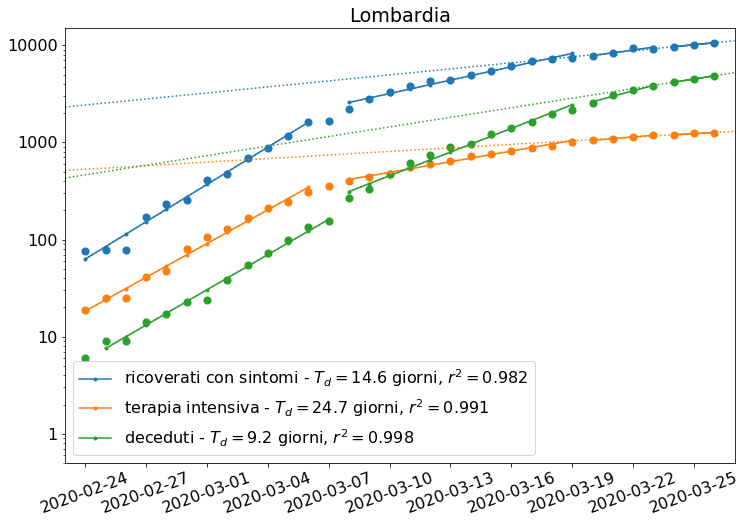

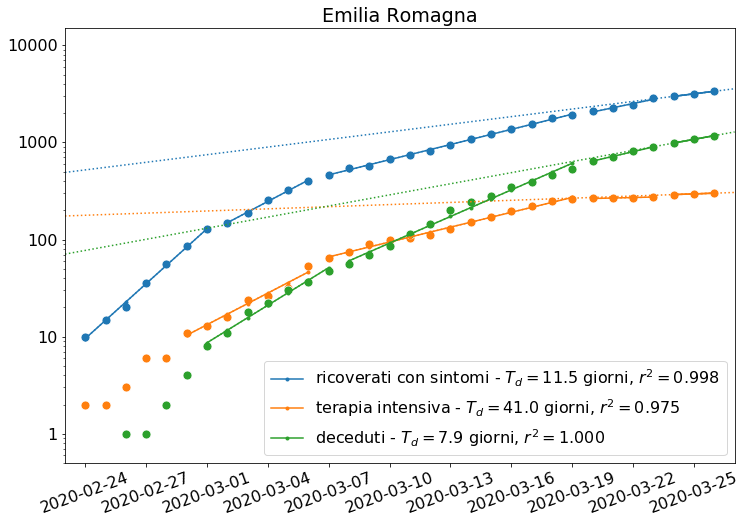

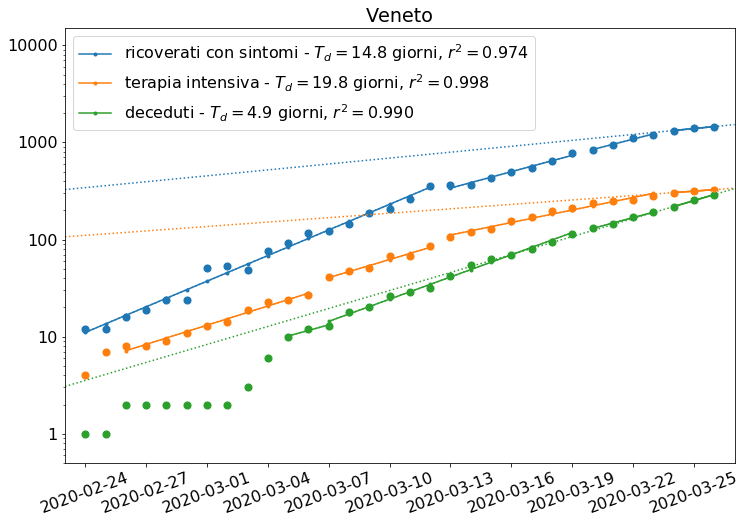

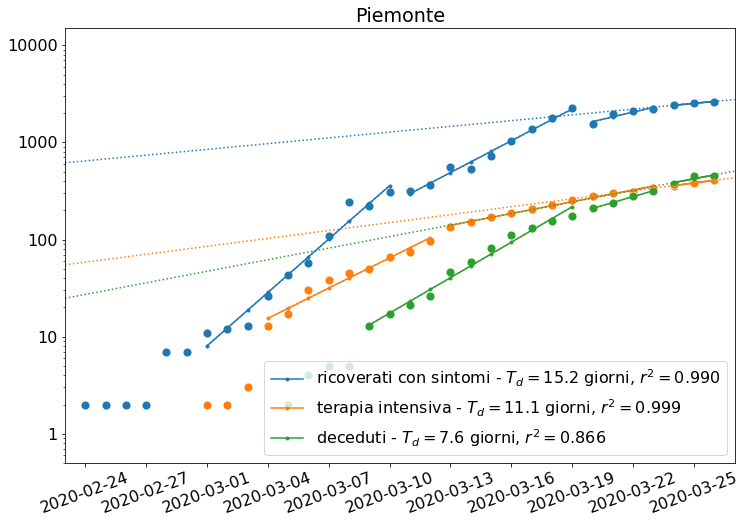

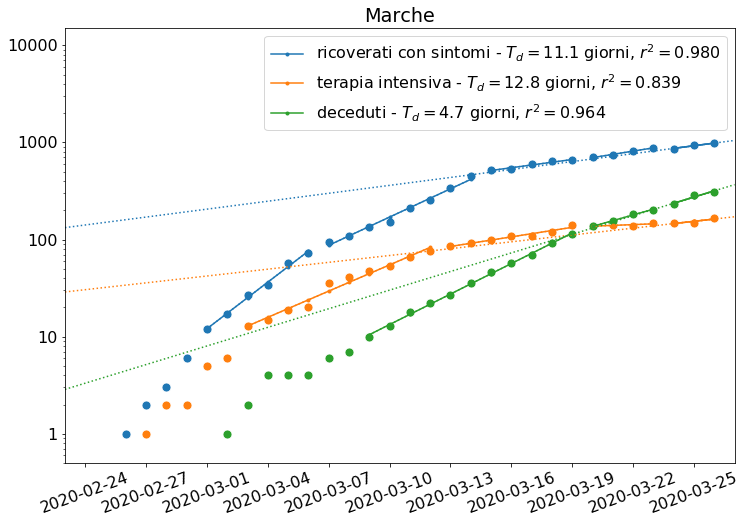

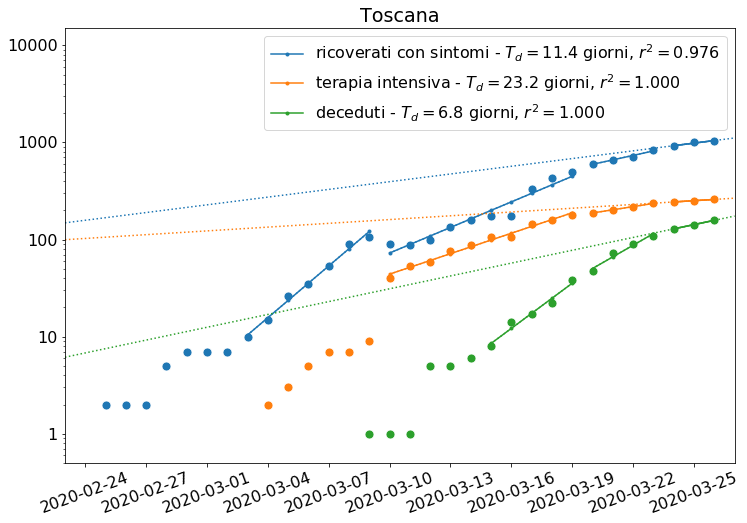

In [ ]:
for region in REGIONS_FIT_PARAMS:
    
        # BGA perdonabile porcata 1
        if len(fits[region, 'ricoverati_con_sintomi']) == 0:
            print('No data for', region)
            continue
        _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (0.5, 15000)}, figsize=(12, 8))
        if bShowLockdowns : _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')
        select = (data_italy_regions['denominazione_regione'] == region)
        try:
            # BGA changed to cycle in SHOW
            for kind, color in zip(SHOW, sns.color_palette()):                
                for fit in fits[region, kind]:
                    covid19.plot.plot_fit(ax, fit,  color=color)
                #covid19.plot.plot_data(ax, data_italy_regions[select][kind], fit.start, fit.stop, color=color, date_interval=3)
                covid19.plot.plot(ax, data_italy_regions[select][kind], fit, label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=3)
                # covid19.plot.plot(ax, data_italy_regions[select][kind], fit, label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=sns.color_palette()[0], date_interval=3)
            
            ax.set_title(region)
        except:
            pass

#_ = ax.set(title=r'COVID-19 "severe" cases in Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')


## Estimate of the initial / uncontined doubling time

In [ ]:
for key, value in list(fits.items())[:10]:
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[0])}')

In [ ]:
for key, value in list(fits.items())[:10]:
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[-1])}')